## Importing necessary libraries

In [1]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import yfinance as yf
from ts2vg import NaturalVG, HorizontalVG
import networkx as nx
from scipy.stats import entropy
from numba import jit
from ordpy import ordinal_distribution
from tqdm import tqdm
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from scipy.spatial import distance
from KDEpy import FFTKDE

## Setting up parameters for graphics

In [2]:
plt.style.use('classic')
plt.rcParams.update({'legend.fontsize': 26})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams['font.size'] = '26'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['savefig.dpi'] = 300
xlabel = 'time, days'

## Defining function for the construction of the recurrence graph

In [3]:
def recurrence_net(time_ser, rec_thr, dim, tau, dist_type='euclidien'):
    time_series = nk.complexity_embedding(time_ser, dimension=dim, delay=tau)
    rp = (distance.cdist(time_series, time_series, dist_type) <= rec_thr).astype(int)
    adj_matrix_RN = rp
    np.fill_diagonal(adj_matrix_RN, 0)

    rec_nw = nx.from_numpy_matrix(adj_matrix_RN)
    
    return rec_nw

def node_positions_recurrence_net(ts, xs):
    return {i: (xs[i], ts[i]) for i in range(len(ts))}

## Defining function for the calculationg of the Costa\`s index 

In [4]:
def Costa_1(time_ser, taus):
    Cst = []
    for tau in taus:
        fragm_Costa = np.array([time_ser[tau:], time_ser[:-tau]])
        DiffCosta = np.diff(fragm_Costa,axis=0)
        IncCosta = np.sum(DiffCosta>0)
        DecCosta = np.sum(DiffCosta<0)
        C = (IncCosta-DecCosta)/(len(time_ser)-tau)
        Cst.append(C)
    Costa = np.mean(np.abs(Cst))
    return Costa

## Defining function for calculationg permutation- and graph-based measures of irreversibility

In [5]:
def PermIrrever(time_ser, d_e, tau, delta=1e-10, distance_irr="kullback"):
    pattern, dist = ordinal_distribution(time_ser, dx=d_e, taux=tau, return_missing=True)
    
    m, n = pattern.shape
    pf = []
    pb = []

    is_used = np.zeros((m))

    for i in range(m):
        if is_used[i] == 1:
            continue

        is_used[i] = 1
        pf.append(i)
        permb = pattern[i,::-1]
        for j in range(m-1,-1,-1):
            if np.sum(pattern[j,:] == permb) == n: 
                is_used[j] = 1
                pb.append(j)
                break
    
    if distance_irr == "kullback":
        KLD_perm = dist[pf] * np.log((dist[pf] + delta) / (dist[pb] + delta))
        return np.sum(KLD_perm)   
    else:
        return distance.jensenshannon(dist[pf] + delta, dist[pb] + delta)


def GraphIrrever(fragm_1, graph_type='classic', delta=1e-10, d_e_rec=3, tau_rec=1, eps_rec=0.1, dist_rec='chebyshev', distance_irr='kullback'):
    
    # constructing graph
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm_1)
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm_1)
    else:
        g = recurrence_net(fragm_1, rec_thr=eps_rec*np.abs(np.std(fragm_1)), dim=d_e_rec, tau=tau_rec, dist_type=dist_rec)
    
    # calculating retarded (advanced) degrees and local clustering coefficients
    adjacency_mat = g.adjacency_matrix()
    ret_deg, adv_deg = GetDegree(adjacency_mat)
    ret_clust, adv_clust = GetLocalClusteringCoefficient(adjacency_mat, ret_deg, adv_deg)
    
    # using kernel density estimator to find pdf
    pdf_ret_deg = gaussian_kde(sorted(ret_deg), bw_method='scott')       
    pdf_adv_deg = gaussian_kde(sorted(adv_deg), bw_method='scott')    
    pdf_ret_clust = gaussian_kde(sorted(ret_clust), bw_method='scott')    
    pdf_adv_clust = gaussian_kde(sorted(adv_clust), bw_method='scott')
    
    a_deg = min(min(ret_deg), min(adv_deg))  
    b_deg = max(max(ret_deg), max(adv_deg))  
    a_clust = min(min(ret_clust), min(adv_clust))
    b_clust = max(max(ret_clust), max(adv_clust))
                           
    if distance_irr == 'kullback':
        dkl_deg = lambda x: pdf_ret_deg.pdf(x) * np.log((pdf_ret_deg.pdf(x) + delta)/(pdf_adv_deg.pdf(x) + delta))        
        dkl_clust = lambda x: pdf_ret_clust.pdf(x) * np.log((pdf_ret_clust.pdf(x) + delta)/(pdf_adv_clust.pdf(x) + delta))

        distance_deg = quad(dkl_deg, a_deg, b_deg)[0]       
        distance_clust = quad(dkl_clust, a_clust, b_clust)[0]
    
    else:                                 
        width_deg = (b_deg-a_deg)/len(ret_deg)
        width_clust = (b_clust-a_clust)/len(ret_clust)

        lin_deg = np.arange(a_deg, b_deg, width_deg) 
        lin_clust = np.arange(a_clust, b_clust, width_clust)

        p_ret_deg = pdf_ret_deg.pdf(lin_deg) 
        p_adv_deg = pdf_adv_deg.pdf(lin_deg) 
        p_ret_clust = pdf_ret_clust.pdf(lin_clust) 
        p_adv_clust = pdf_adv_clust.pdf(lin_clust)
    
        distance_deg = distance.jensenshannon(p_ret_deg + delta, p_adv_deg + delta)
        distance_clust = distance.jensenshannon(p_ret_clust + delta, p_adv_clust + delta)
      
    return distance_deg, distance_clust


@jit(nopython=True, nogil=True) 
def GetDegree(AM):
    numNodes = AM.shape[0]
    retarded_degree = np.zeros((numNodes))
    advanced_degree = np.zeros((numNodes))
     
    for i in range(numNodes):
        retarded_degree[i] = AM[i, :i].sum()

    for i in range(numNodes):
        advanced_degree[i] = AM[i, i:].sum()
        
    return retarded_degree, advanced_degree
    
    
@jit(nopython=True, nogil=True) 
def GetLocalClusteringCoefficient(AM, ret_deg, adv_deg):
    
    numNodes = AM.shape[0]
    retardedCC = np.zeros( (numNodes) )
    advancedCC = np.zeros( (numNodes) )
    ret_norm = ret_deg * (ret_deg - 1) / 2
    adv_norm = adv_deg * (adv_deg - 1) / 2
    
    for i in range(numNodes):
        if ret_norm[i] != 0: 
            counter = 0
            
            for j in range(i):
                for k in range(j): 
                    if AM[i, j] == 1 and AM[j, k] == 1 and AM[k, i] == 1: 
                        counter += 1
                        
            retardedCC[i] = counter / ret_norm[i]
    
    for i in range(numNodes-2):
        if adv_norm[i] != 0: 
            counter = 0
            
            for j in range(i+1, numNodes):
                for k in range(i+1, j): 
                    if AM[i, j] == 1 and AM[j, k] == 1 and AM[k, i] == 1: 
                        counter += 1
                        
            advancedCC[i] = counter / adv_norm[i]
                 
                
    return retardedCC, advancedCC

## Getting data from Yahoo! Finance

In [169]:
name_1 = "^DJI"
name_2 = "^DJI"
data = yf.download(symbol)
time_ser_1 = data['Adj Close'].copy()
for_graph = data['Adj Close'].copy()

date_in_num = mdates.date2num(time_ser_1.index)

np.savetxt(f'{name_1}_initial_time_series.txt', time_ser_1.values)

[*********************100%***********************]  1 of 1 completed


## Getting data from .txt files

In [6]:
name_1 = "WTI_short_5_1_1.txt" # the name of file for making computations

In [7]:
with open(name_1, 'r') as f1: # reading file
    time_ser_1 = [line.strip('\n') for line in f1.readlines()]
    time_ser_1 = [float(line) for line in time_ser_1 if line != '']
time_ser_1 = pd.Series(time_ser_1) # converting to pandas dataframe for using its built-in functions 
date_in_num = time_ser_1.index 

In [8]:
name_2 = "WTI_short_5_1_1.txt" # the name of file for graphics

In [9]:
with open(name_2, 'r') as f2: #зчитуємо файл
    time_ser_2 = [line.strip('\n') for line in f2.readlines()]
    time_ser_2 = [float(line) for line in time_ser_2 if line != '']
for_graph = pd.Series(time_ser_2) # converting to pandas dataframe for using its built-in functions 

## Plotting the studies series

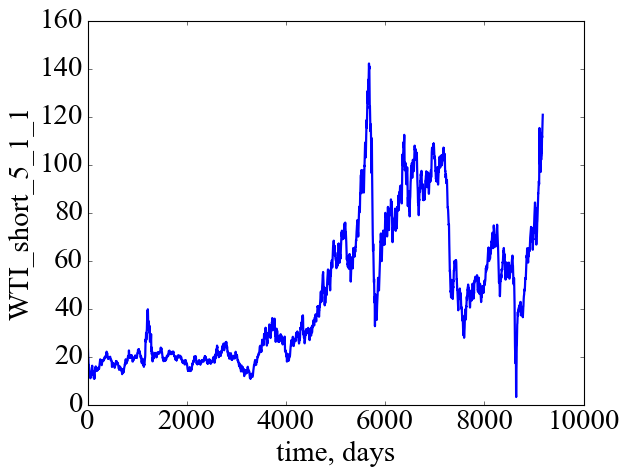

In [10]:
time_ser_1.plot(figsize=(8,6), xlabel=xlabel, ylabel=fr"{name_1.split('.')[0]}")
plt.savefig('ts1.jpg', bbox_inches="tight")
plt.show()

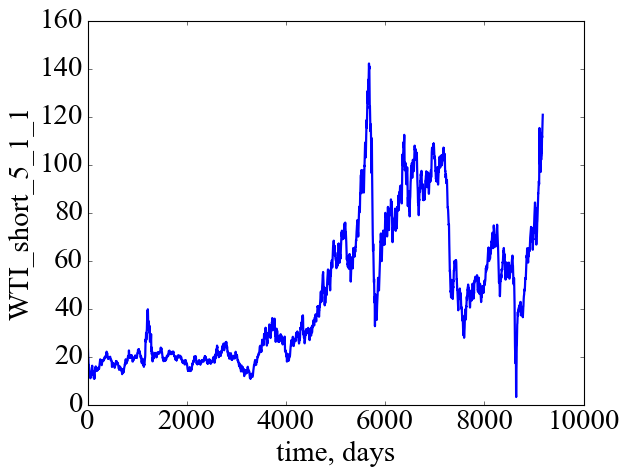

In [11]:
for_graph.plot(figsize=(8,6), xlabel=xlabel, ylabel=fr"{name_2.split('.')[0]}")
plt.savefig('ts2.jpg', bbox_inches="tight")
plt.show()

## Setting the parameters of the studies series

In [176]:
window = 500 # size of the sliding window
tstep = 5 # time step

ret_type = 4 # type of series: 1 - initial, 2 - detrended (difference between current value and previous)
                        # 3 - standard returns, 4 - standardized returns, 5 - absolute values (volatility)
                        # 6 - standardized time series


# for the recurrence graph
d_e_rec = 3 # embedding dimension
tau_rec = 1 # time delay
eps_rec = 1.3 # radius
dist_rec = 'chebyshev' # distance for the recurrence plot: canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
                                                        # ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, 
                                                        # ‘jensenshannon’, ‘kulsinski’, ‘kulczynski1’, ‘mahalanobis’, 
                                                        # ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, 
                                                        # ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.


# for the measures of irreversibility
d_e_perm = 4 # embedding dimension for permutation irreversibility
tau_perm  = 15 # time delay for permutation irreversibility
distance_irr = 'shannon' # distance between two distributions: kullback, shannon
graph_type = 'classic' # type of graph irreversibility: classic, horizontal, recurrent

# parameters for asymmetry
tau_assym = 1
tau_Costa_begin = 1
tau_Costa_end = 10
taus_Costa = np.arange(tau_Costa_begin, tau_Costa_end+1)
                
length = len(time_ser_1)

## Plotting the Poincaré diagram and calculating the measures on its basis

In [130]:
for_puank = time_ser_1.copy()

if ret_type == 1:
    pass
elif ret_type == 2:
    for_puank = for_puank.diff()
elif ret_type == 3:
    for_puank = for_puank.pct_change()
elif ret_type == 4:
    for_puank = for_puank.pct_change()
    for_puank -= for_puank.mean()
    for_puank /= for_puank.std()
elif ret_type == 5: 
    for_puank = for_puank.pct_change()
    for_puank -= for_puank.mean()
    for_puank /= for_puank.std()
    for_puank = for_puank.abs()
elif ret_type == 6:
    for_puank -= for_puank.mean()
    for_puank /= for_puank.std()

for_puank = for_puank.dropna().values

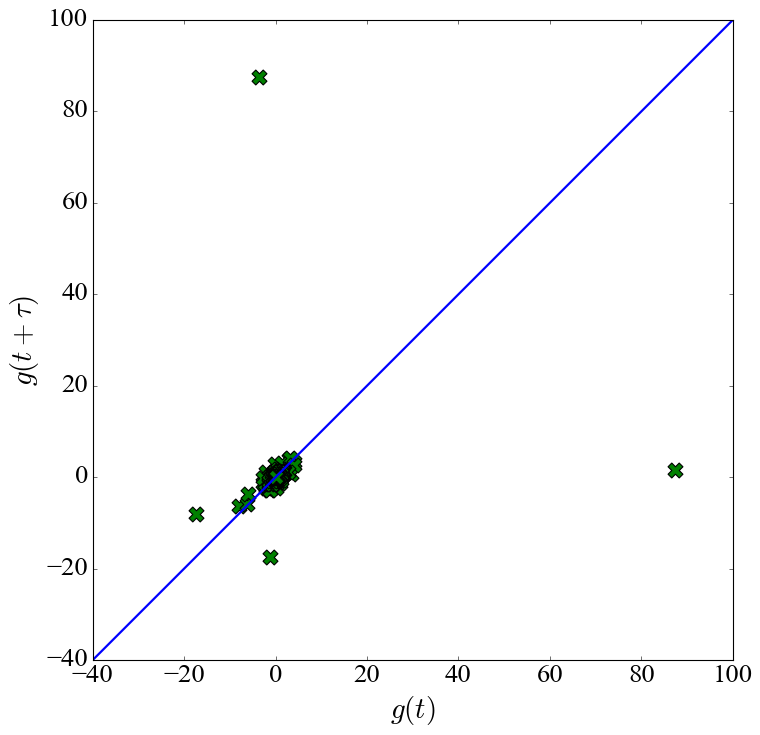

In [131]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))

ax1.scatter(for_puank[:-tau_assym],for_puank[tau_assym:], marker="X", s=180, c="g")

low_x, high_x = ax1.get_xlim()
low_y, high_y = ax1.get_ylim()
ax1.axline([low_x, low_y], [high_x, high_y])

ax1.set_aspect('equal', 'box')
ax1.set_xlabel(r'$g(t)$', fontsize=26)
ax1.set_ylabel(r'$g(t+\tau)$', fontsize=26) 
ax1.set_xlim(left=low_x, right=high_x)
ax1.set_ylim(bottom=low_y, top=high_y)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.locator_params(axis='y', nbins=7)
#plt.xlabel("xlabel", fontsize=26)

plt.savefig(f"Poincare_plot_{name_2.split('.')[0]}_{tau_assym}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

## Calculations with the sliding window procedure

### Arrays for saving the results of calculations

In [187]:
PIx = []
GIx = []
SIx = []
AIx = []
EIx = []
CIx = []

### Calculating corresponding measures

In [188]:
for i in range(0,length-window,tstep):
    fragm_1 = time_ser_1.iloc[i:i+window].copy() #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm_1 = fragm_1.diff()
    elif ret_type == 3:
        fragm_1 = fragm_1.pct_change()
    elif ret_type == 4:
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
    elif ret_type == 5: 
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        fragm_1 = fragm_1.abs()
    elif ret_type == 6:
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        
    fragm_1 = fragm_1.dropna().values 
    
    Temp_fragm = np.array([fragm_1[:-tau_assym], fragm_1[tau_assym:]])
    
    
    T2   = np.transpose(np.arctan(Temp_fragm[1,:]/Temp_fragm[0,:])*180/np.pi)
    Dup  = abs(np.diff(Temp_fragm[:,T2>45],axis=0))
    Dtot = abs(np.diff(Temp_fragm[:,T2!=45],axis=0))
    Sup  = np.sum(abs(T2[T2>45]-45))
    Stot = np.sum(abs(T2[T2!=45]-45))
    Aup  = np.sum(abs(np.transpose(((T2[T2>45]-45))*np.sqrt(np.sum(Temp_fragm[:,T2>45]**2,axis=0)))))
    Atot = np.sum(abs(np.transpose(((T2[T2!=45]-45))*np.sqrt(np.sum(Temp_fragm[:,T2!=45]**2,axis=0)))))
    Ethird = np.sum(np.transpose(Temp_fragm[0,:]-Temp_fragm[1,:])**3)
    Etot = (np.sum(np.transpose(Temp_fragm[0,:]-Temp_fragm[1,:])**2))**(3/2)

    
    Porta = sum(T2<45)/sum(T2!=45)
    Gudzik = np.sum(Dup**2)/np.sum(Dtot**2)
    Slope = Sup/Stot
    Area = Aup/Atot
    Eiler = Ethird/Etot
    Costa = Costa_1(fragm_1, taus_Costa)
    
    PIx.append(Porta)
    GIx.append(Gudzik)
    SIx.append(Slope)
    AIx.append(Area)
    EIx.append(Eiler)
    CIx.append(Costa)

### Saving absolute values into text files

In [189]:
np.savetxt(f"Porta_idx_{name_1}_{window}_{tstep}_{ret_type}_{tau_assym}.txt", PIx)
np.savetxt(f"Gudzik_idx_{name_1}_{window}_{tstep}_{ret_type}_{tau_assym}.txt", GIx)
np.savetxt(f"Slope_idx_{name_1}_{window}_{tstep}_{ret_type}_{tau_assym}.txt", SIx)
np.savetxt(f"Area_idx_{name_1}_{window}_{tstep}_{ret_type}_{tau_assym}.txt", AIx)
np.savetxt(f"Eiler_idx_{name_1}_{window}_{tstep}_{ret_type}_{tau_assym}.txt", EIx)
np.savetxt(f"Costa_idx_{name_1}_{window}_{tstep}_{ret_type}_{tau_assym}.txt", CIx)

### Scaling values between 0 and 1

In [190]:
Porta_idx = np.asarray(PIx).reshape(-1, 1)
Gudzik_idx = np.asarray(GIx).reshape(-1, 1)
Slope_idx = np.asarray(SIx).reshape(-1, 1)
Area_idx = np.asarray(AIx).reshape(-1, 1)
Eiler_idx = np.asarray(EIx).reshape(-1, 1)
Costa_idx = np.asarray(CIx).reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()

scaled_Porta_idx = min_max_scaler.fit_transform(Porta_idx)
scaled_Gudzik_idx = min_max_scaler.fit_transform(Gudzik_idx)
scaled_Slope_idx = min_max_scaler.fit_transform(Slope_idx)
scaled_Area_idx = min_max_scaler.fit_transform(Area_idx)
scaled_Eiler_idx = min_max_scaler.fit_transform(Eiler_idx)
scaled_Costa_idx = min_max_scaler.fit_transform(Costa_idx)
scaled_Close_1 = min_max_scaler.fit_transform(time_ser_1.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

### Plotting Porta\`s index

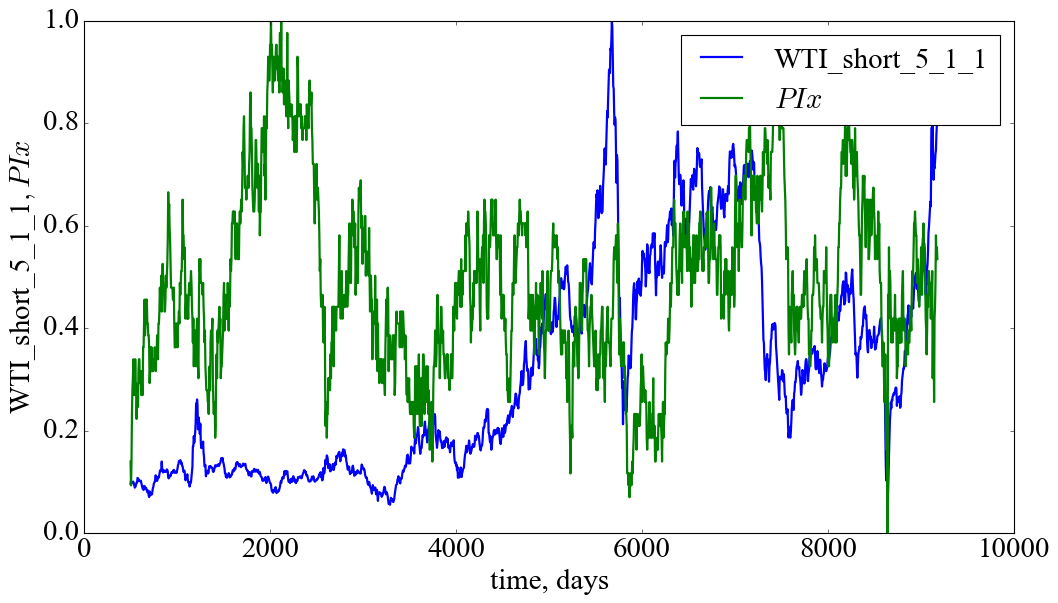

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_Porta_idx, label=r"$PIx$")

ax.legend()

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$PIx$")

plt.savefig(f"PIx_{name_2.split('.')[0]}_{tau_assym}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

### Plotting Guzik\`s index

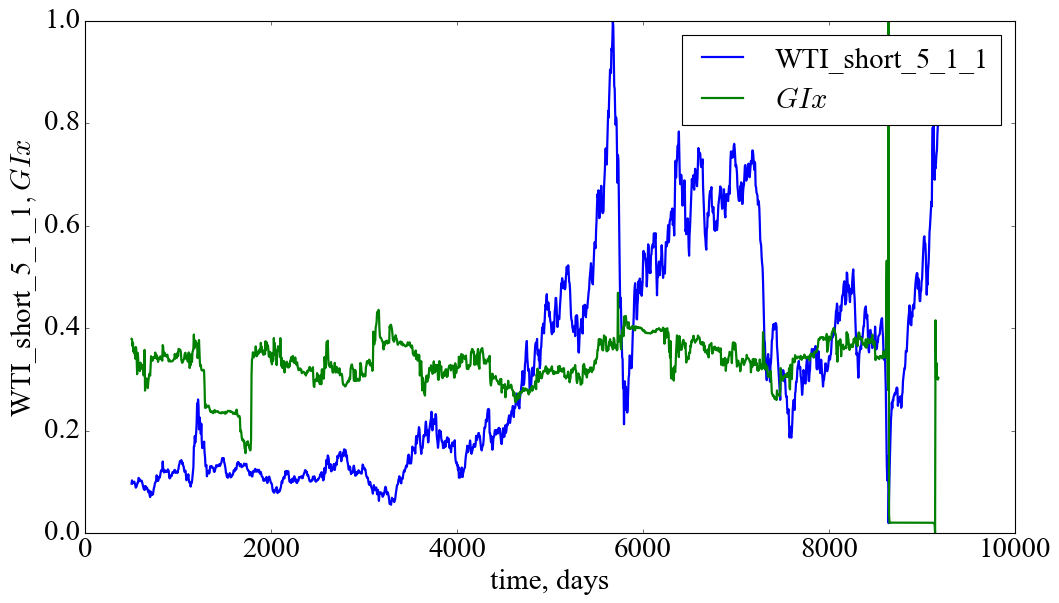

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_Gudzik_idx, label=r"$GIx$")

ax.legend()

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$GIx$")

plt.savefig(f"GIx_{name_2.split('.')[0]}_{tau_assym}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

### Plotting Slope index

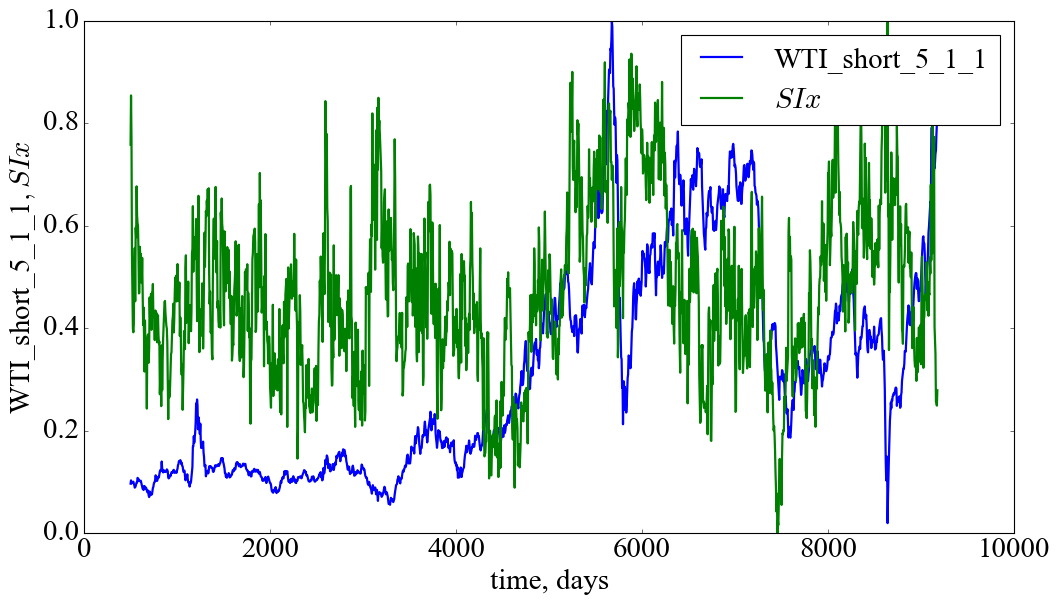

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_Slope_idx, label=r"$SIx$")

ax.legend()

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$SIx$")

plt.savefig(f"SIx_{name_2.split('.')[0]}_{tau_assym}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

### Plotting Area index

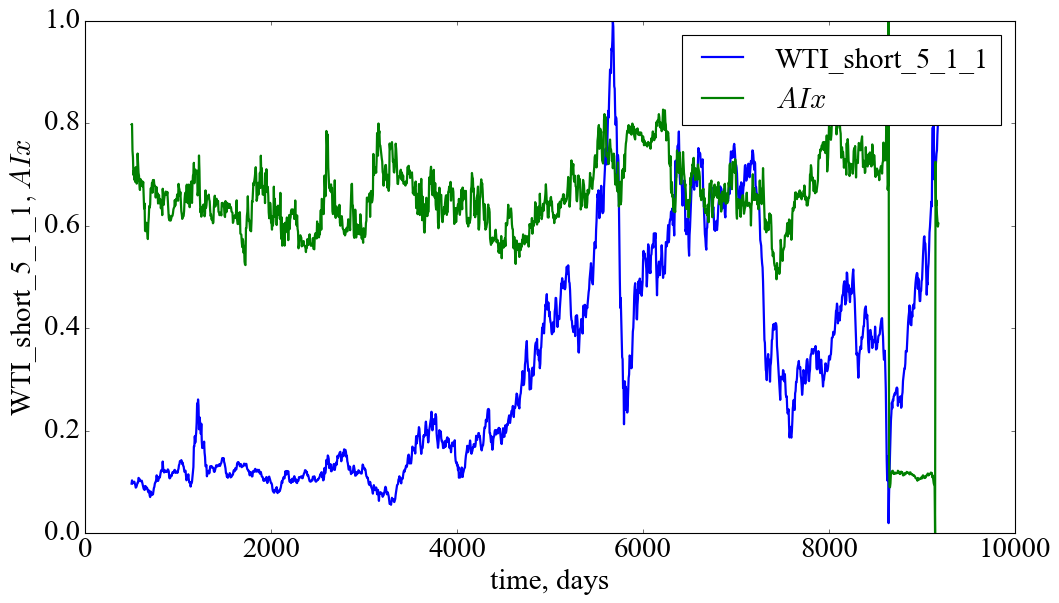

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_Area_idx, label=r"$AIx$")

ax.legend()

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$AIx$")

plt.savefig(f"AIx_{name_2.split('.')[0]}_{tau_assym}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

### Plotting Ehlers\` index

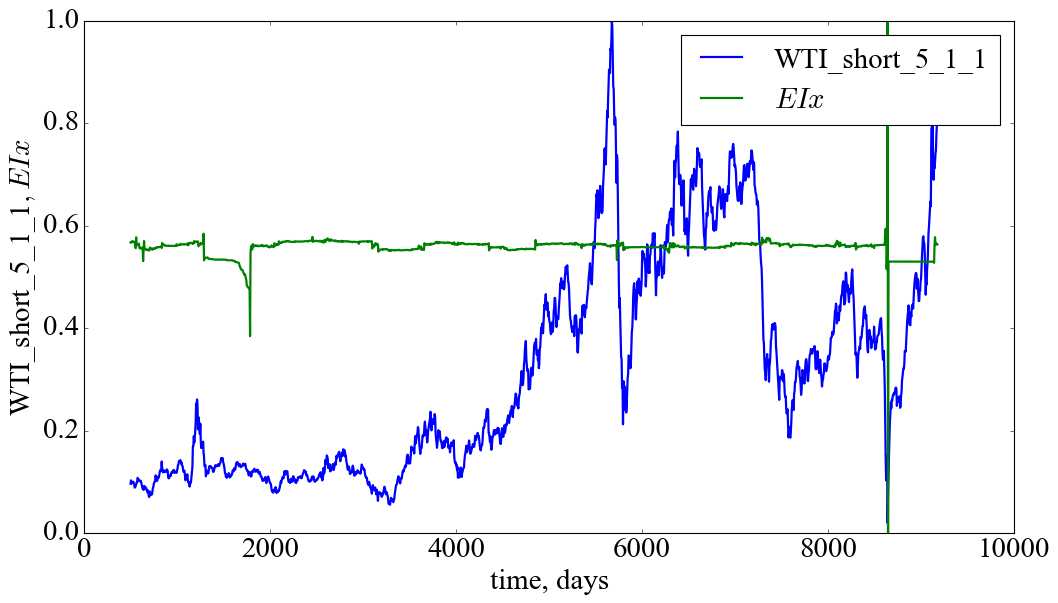

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_Eiler_idx, label=r"$EIx$")

ax.legend()

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$EIx$")

plt.savefig(f"EIx_{name_2.split('.')[0]}_{tau_assym}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

### Plotting Costa\`s index

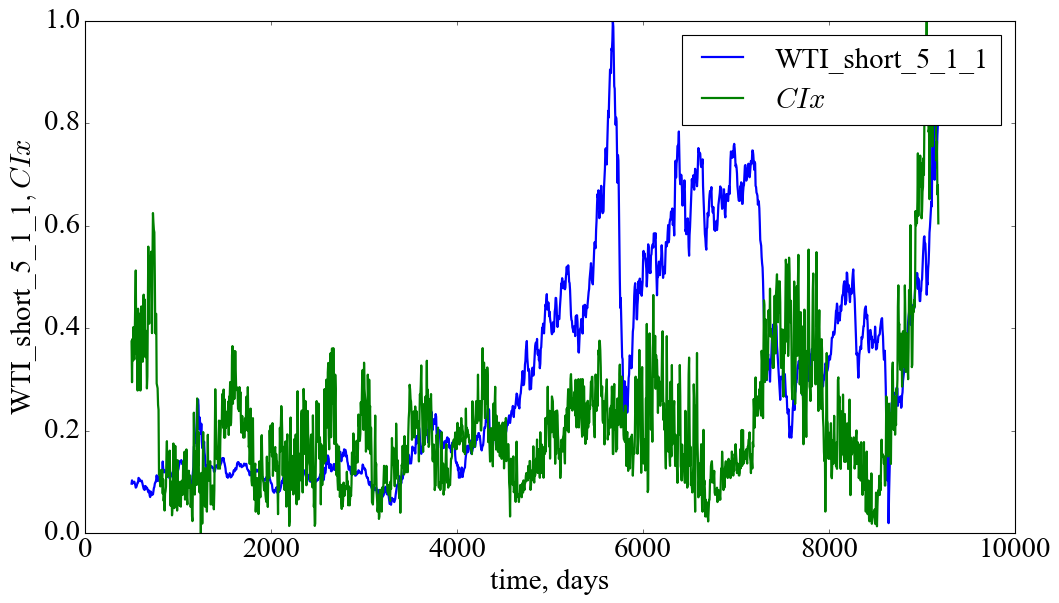

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_Costa_idx, label=r"$CIx$")

ax.legend()

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$CIx$")

plt.savefig(f"CIx_{name_2.split('.')[0]}_{tau_assym}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

## Constructing the graph of a studied time series

In [177]:
index_begin = 5000
index_end = 6000

for_graph_plot = time_ser_1.copy()

if ret_type == 1:
    pass
elif ret_type == 2:
    for_graph_plot = for_graph_plot.diff()
elif ret_type == 3:
    for_graph_plot = for_graph_plot.pct_change()
elif ret_type == 4:
    for_graph_plot = for_graph_plot.pct_change()
    for_graph_plot -= for_graph_plot.mean()
    for_graph_plot /= for_graph_plot.std()
elif ret_type == 5: 
    for_graph_plot = for_graph_plot.pct_change()
    for_graph_plot -= for_graph_plot.mean()
    for_graph_plot /= for_graph_plot.std()
    for_graph_plot = for_graph_plot.abs()
elif ret_type == 6:
    for_graph_plot -= for_graph_plot.mean()
    for_graph_plot /= for_graph_plot.std()

for_graph_plot = for_graph_plot.copy().dropna().values

date = date_in_num[index_begin:index_end]

if graph_type == 'classic':
    g = NaturalVG(directed=None).build(for_graph_plot[index_begin:index_end], xs=date)
    pos = g.node_positions()
    nxg = g.as_networkx()
elif graph_type == 'horizontal':
    g = HorizontalVG(directed=None).build(for_graph_plot[index_begin:index_end], xs=date)
    pos = g.node_positions()
    nxg = g.as_networkx()
else:
    g = recurrence_net(for_graph_plot[index_begin:index_end], 
                       rec_thr=eps_rec * np.abs(np.std(for_graph_plot[index_begin:index_end])), 
                       dim=d_e_rec, 
                       tau=tau_rec, 
                       dist_type=dist)
    
    pos = node_positions_recurrence_net(for_graph_plot[index_begin:index_end], date)
    nxg = g
    
    


graph_plot_options = {
    'with_labels': False,
    'node_size': 2,
    'node_color': [(0, 0, 0, 1)],
    'edge_color': [(0, 0, 0, 0.15)],
}


## Plotting the visibility connections

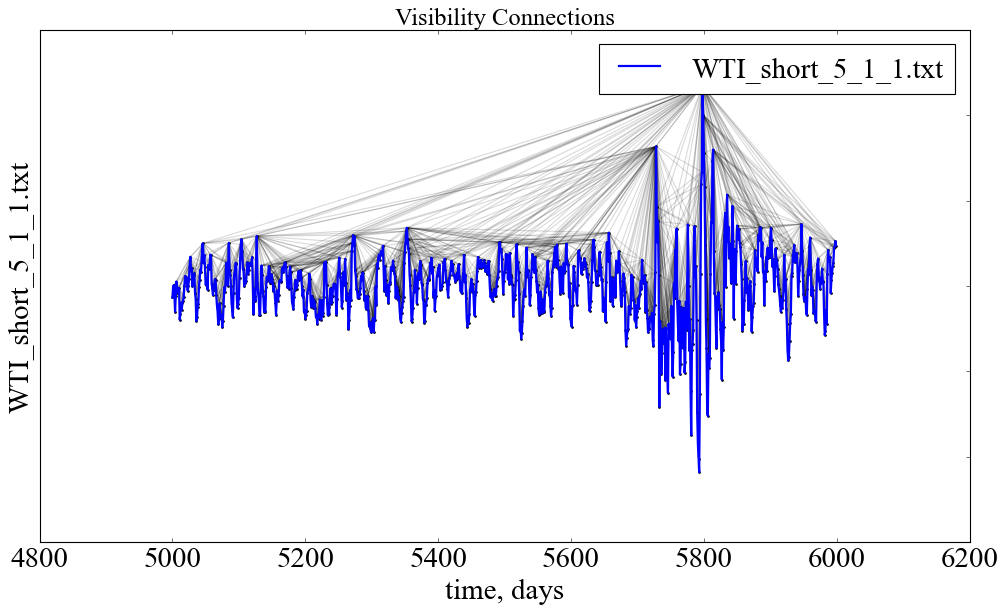

In [178]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

nx.draw_networkx(nxg, ax=ax1, pos=pos, **graph_plot_options)
ax1.tick_params(bottom=True, labelbottom=True)
ax1.plot(time_ser_1.index[index_begin:index_end], for_graph_plot[index_begin:index_end], label=fr"{name_2}")
ax1.set_title('Visibility Connections', fontsize=22)
ax1.set_xlabel(xlabel)
ax1.set_ylabel(fr"{name_2}")
ax1.legend(loc='upper right')

plt.savefig(f"Time_ser_connections_symbol={name_2}_idx_beg={index_begin}_idx_end={index_end}_sertype={ret_type}_network_type={graph_type}.jpg", bbox_inches="tight")
plt.show()

## Plotting the graph

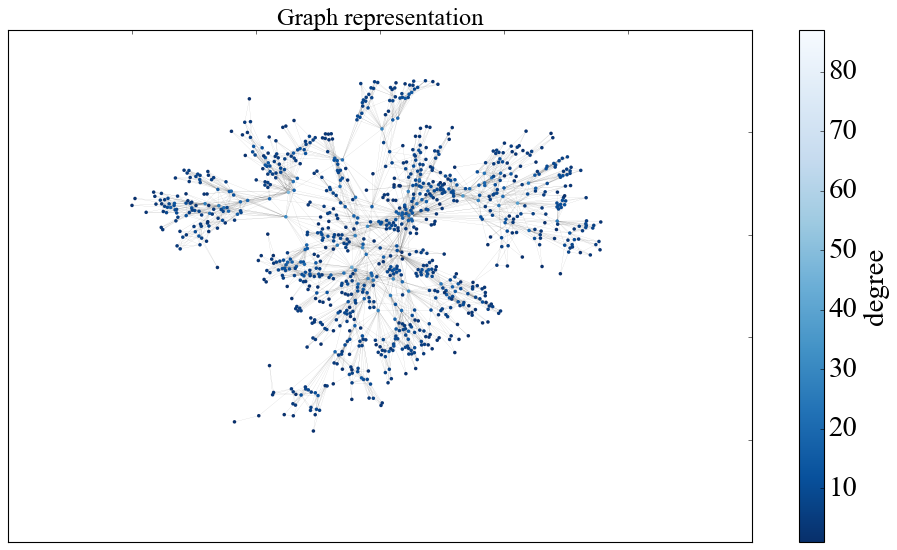

In [179]:
pos = nx.spring_layout(nxg,k=0.15,iterations=100)
# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos: #helps in color code nodes
    x, y = pos[n]
    d = (x - 0.5)**2 + (y - 0.5)**2
    if d < dmin:
        ncenter = n
        dmin = d

#color by degree
p = dict(nx.degree(nxg))
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax2.set_title('Graph representation', fontsize=22)
nx.draw_networkx_edges(nxg, ax=ax2, pos=pos, nodelist=[ncenter], alpha=0.4,width=0.1)
nx.draw_networkx_nodes(nxg, ax=ax2, pos=pos, nodelist=list(p.keys()),
                       node_size=10, edgecolors='r', linewidths=0.01,
                       node_color=list(p.values()),
                       cmap=plt.cm.Blues_r)
        
vmin = np.asarray(list(p.values())).min()
vmax = np.asarray(list(p.values())).max()

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues_r, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = plt.colorbar(sm, ax=ax2)
cb.set_label('degree')
#sm.set_array([])
#plt.axis('off')

plt.savefig(f"Graph_representation_symbol={name_2}_idx_beg={index_begin}_idx_end={index_end}_sertype={ret_type}_network_type={graph_type}.jpg", bbox_inches="tight")
plt.show()

## Constructing measures of irreversibility using permutation-based method and graph-based indicators

## In window

### Arrays for saving the results of calculations

In [180]:
DegreeKulb = []
ClustKulb = []
PermKulb = []

### Calculating corresponding measures

In [181]:
for i in range(0,length-window,tstep):
    fragm_1 = time_ser_1.iloc[i:i+window].copy() #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm_1 = fragm_1.diff()
    elif ret_type == 3:
        fragm_1 = fragm_1.pct_change()
    elif ret_type == 4:
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
    elif ret_type == 5: 
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        fragm_1 = fragm_1.abs()
    elif ret_type == 6:
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        
    fragm_1 = fragm_1.dropna().values
        
    KL_deg, KL_clust = GraphIrrever(fragm_1, 
                                    graph_type=graph_type, 
                                    delta=1e-10, 
                                    d_e_rec=d_e_rec, 
                                    tau_rec=tau_rec, 
                                    eps_rec=eps_rec, 
                                    dist_rec=dist_rec, 
                                    distance_irr=distance_irr)  
    
    KL_perm = PermIrrever(fragm_1, 
                          d_e=d_e_perm, 
                          tau=tau_perm, 
                          delta=1e-10, 
                          distance_irr=distance_irr)
      
    DegreeKulb.append(KL_deg)
    ClustKulb.append(KL_clust)
    PermKulb.append(KL_perm)

### Saving results to .txt files

In [182]:
np.savetxt(f"KL_deg_symbol={name_1}_wind={window}_step={tstep}_ret_type={ret_type}_graph_type={graph_type}.txt",DegreeKulb)
np.savetxt(f"KL_clust_symbol={name_1}_wind={window}_step={tstep}_ret_type={ret_type}_graph_type={graph_type}.txt",ClustKulb)
np.savetxt(f"KL_perm_symbol={name_1}_wind={window}_step={tstep}_ret_type={ret_type}_d_e={d_e_perm}_tau={tau_perm}.txt",PermKulb)

### Scaling calculations between 0 and 1

In [183]:
KL_Degrees = np.asarray(DegreeKulb).reshape(-1, 1)
KL_Clusts = np.asarray(ClustKulb).reshape(-1, 1)
KL_Perms = np.asarray(PermKulb).reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()

scaled_KL_Degrees = min_max_scaler.fit_transform(KL_Degrees)
scaled_KL_Clusts = min_max_scaler.fit_transform(KL_Clusts)
scaled_KL_Perms = min_max_scaler.fit_transform(KL_Perms)

scaled_Close_1 = min_max_scaler.fit_transform(time_ser_1.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

### Plotting degree irreversibility

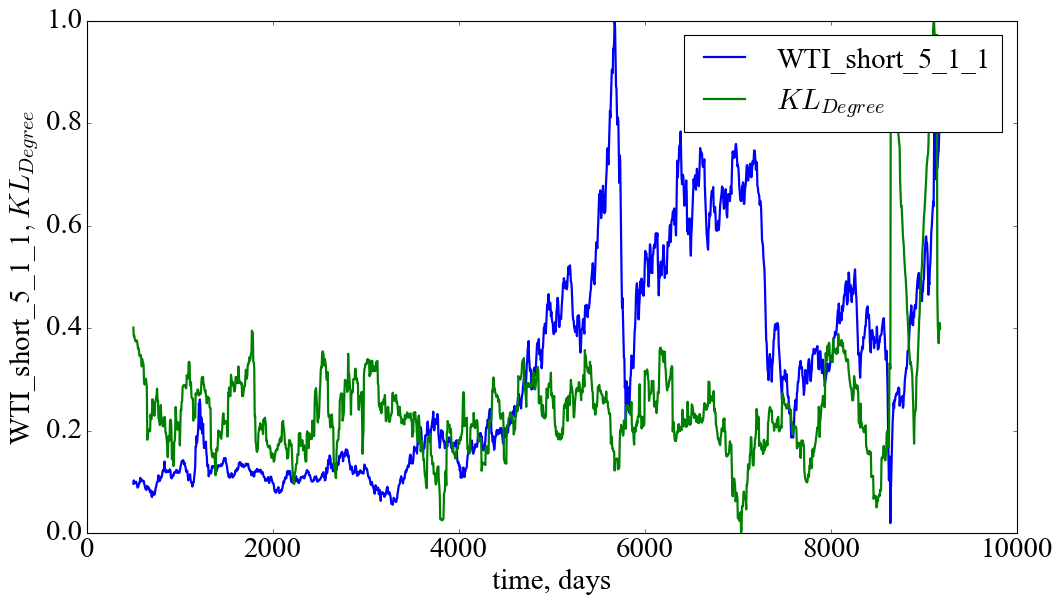

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_KL_Degrees, label=r"$KL_{Degree}$")

ax.legend()

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$KL_{Degree}$")

plt.savefig(f"KL_Degree_symbol={name_1}_wind={window}_step={tstep}_ret_type={ret_type}_graph_type={graph_type}.jpg", bbox_inches="tight")
plt.show()

### Plotting clustering irreversibility

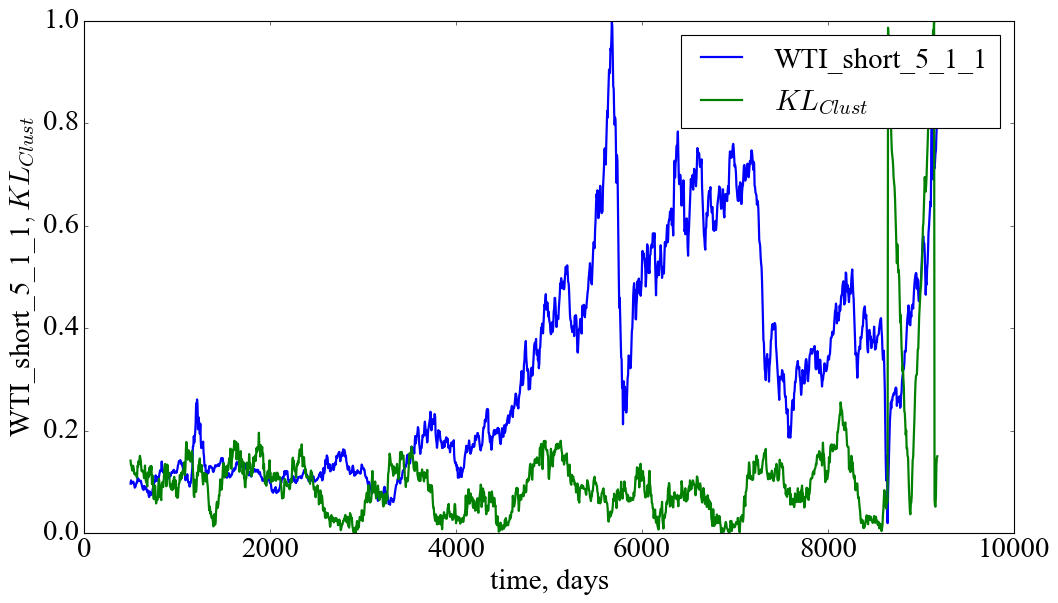

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_KL_Clusts, label=r"$KL_{Clust}$")

ax.legend()

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$KL_{Clust}$")

plt.savefig(f"KL_Clust_symbol={name_1}_wind={window}_step={tstep}_ret_type={ret_type}_graph_type={graph_type}.jpg", bbox_inches="tight")
plt.show()

### Plotting permutation irreversibility

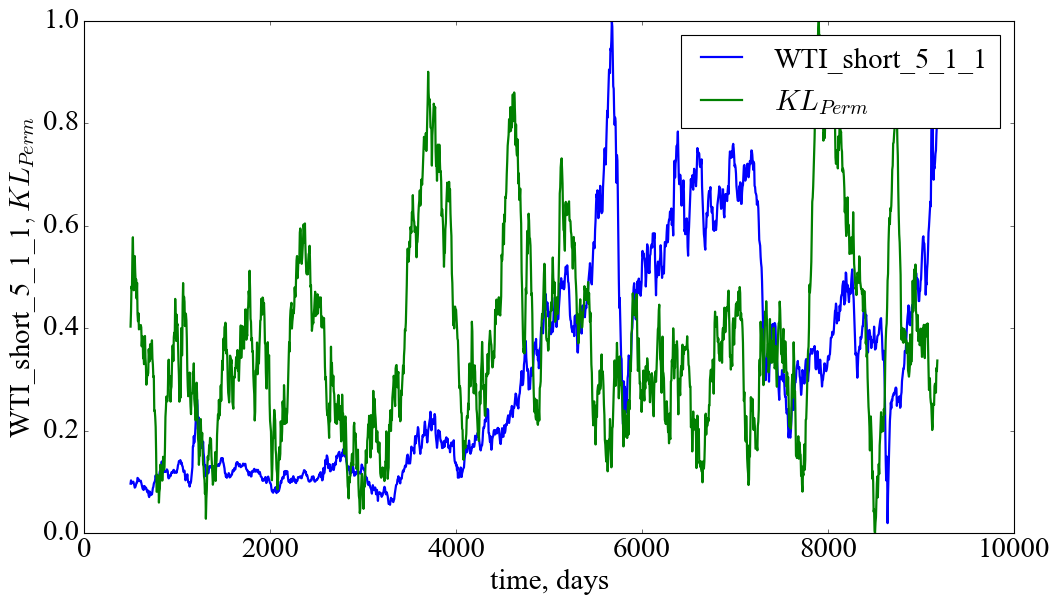

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_KL_Perms, label=r"$KL_{Perm}$")

ax.legend()

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$KL_{Perm}$")

plt.savefig(f"KL_Perm_symbol={name_1}_wind={window}_step={tstep}_ret_type={ret_type}_d_e={d_e_perm}_tau={tau_perm}.jpg", bbox_inches="tight")
plt.show()